<a href="https://colab.research.google.com/github/karenwhite33/NLP_Sentiment_Analysis_User_Reviews/blob/main/2_Data_EDA_NLP_Amazon_Sent_Analysis_scientific_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2_Normalizaci√≥n**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install stop-words

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=c6bcf360107947057112aa7eb410b8447fe3c0214037b90cd18ca2ce8032f78a
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [4]:
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploraci√≥n
from nltk import ngrams # Exploraci√≥n
from nltk.probability import FreqDist # Exploraci√≥n
from stop_words import get_stop_words # Preprocesado
import unicodedata # Preprocesado
import re # Preprocesado


import matplotlib.pyplot as plt

In [ ]:
# Cargar el df_clean (balanceado y limpio) desde el archivo Pickle
df_clean = pd.read_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean2.pkl")

In [ ]:
# Eliminar la columna 'num_words' despu√©s del Counter
df_clean.drop(columns=['num_words'], inplace=True)

# Verifica que la columna haya sido eliminada
df_clean.head()

review  sentiment
0  These masks are great even though there is no ...          5
1  These scissors are so good they got stolen by ...          5
2  Good. Sensor push easier to work with but thes...          4
3  Great ORB finish & size. Bought for our laundr...          5
4  Wow the sticking power on this stuff is crazy....          4

In [ ]:
df_clean.shape

(10000, 2)

# **1. Limpieza de texto**

 1. Eliminar√© etiquetas HTML
 2. Convertir√© los n√∫meros a palabras
 3. Eliminar√© caracteres especiales (excepto palabras)
 4. Convertir√© el texto a min√∫sculas
 5. Eliminar√© espacios al inicio y al final

In [ ]:
pip install num2words

In [ ]:
import re
from num2words import num2words
from bs4 import BeautifulSoup

# Funci√≥n de limpieza de texto (primer paso)
def clean_text(text):
    # 1. Eliminar etiquetas HTML usando BeautifulSoup pues hay bastantes rese√±as con html
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Convertir los n√∫meros a palabras
    text = re.sub(r'\b\d+\b', lambda x: num2words(int(x.group())), text)

    # 3. Eliminar caracteres especiales (excepto las palabras)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Convertir el texto a min√∫sculas
    text = text.lower()

    # 5. Eliminar espacios al inicio y al final
    text = text.strip()

    return text

# Aplicar la limpieza de texto al DataFrame de rese√±as
df_clean['cleaned_review'] = df_clean['review'].apply(clean_text)

# Verificar las primeras filas despu√©s de la limpieza
print(df_clean[['review', 'cleaned_review']].head())


<ipython-input-121-8eacd850e8bb>:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


                                              review  \
0  These masks are great even though there is no ...   
1  These scissors are so good they got stolen by ...   
2  Good. Sensor push easier to work with but thes...   
3  Great ORB finish & size. Bought for our laundr...   
4  Wow the sticking power on this stuff is crazy....   

                                      cleaned_review  
0  these masks are great even though there is no ...  
1  these scissors are so good they got stolen by ...  
2  good sensor push easier to work with but these...  
3  great orb finish  size bought for our laundry ...  
4  wow the sticking power on this stuff is crazy ...  


In [ ]:
df_clean.head()

review  sentiment  \
0  These masks are great even though there is no ...          5   
1  These scissors are so good they got stolen by ...          5   
2  Good. Sensor push easier to work with but thes...          4   
3  Great ORB finish & size. Bought for our laundr...          5   
4  Wow the sticking power on this stuff is crazy....          4   

                                      cleaned_review  
0  these masks are great even though there is no ...  
1  these scissors are so good they got stolen by ...  
2  good sensor push easier to work with but these...  
3  great orb finish  size bought for our laundry ...  
4  wow the sticking power on this stuff is crazy ...

# **Identificaci√≥n de palabras frecuentes antes de eliminar StopWords**

En la etapa exploratoria pude revisar que hay varios ejemplos de palabras stopwords que al eliminar hacian perder el algunos contextos en frases.

***Ejemplo: "it does the job"***

Al hacer la limpieza de stopwords la frase perdia un poco el sentido pues solo quedaba la palabra "job" y esa frase, asi como otras, pueden ayudar al sentiment de las rese√±as por que esta confirmando que el producto funciona y gracias a esto se le da una calificaci√≥n.

Guardare las palabras mas frecuentes en bigrams y trigrams para giardar un diccionario con estas y cuando haga el trabajo de eliminacion de stopwords para que las preserve y retornen.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Funci√≥n para identificar las palabras m√°s frecuentes
def get_frequent_phrases(reviews, top_n=200):
    vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
    X = vectorizer.fit_transform(reviews)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

    # Ordenar las palabras por frecuencia
    sorted_phrases = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return [phrase[0] for phrase in sorted_phrases[:top_n]]  # Selecciona las top_n frases frecuentes

# Obtener las 200 frases m√°s frecuentes
key_phrases = get_frequent_phrases(df_clean['cleaned_review'].values, top_n=200)

# Mostrar los primeros 50 ejemplos de las frases m√°s frecuentes
print("50 Most Frequent Phrases:")
for i, phrase in enumerate(key_phrases[:50]):
    print(f"{i+1}. {phrase}")


50 Most Frequent Phrases:
1. easy use
2. works great
3. dont know
4. ive used
5. highly recommend
6. good quality
7. make sure
8. waste money
9. duct tape
10. great product
11. high quality
12. heavy duty
13. im happy
14. didnt work
15. im sure
16. work great
17. good product
18. did work
19. doesnt work
20. great price
21. worked great
22. click button
23. great value
24. stainless steel
25. rest life
26. good value
27. best life
28. god bless
29. life best
30. life best life
31. rest life best
32. does work
33. good price
34. looks like
35. review hope
36. really like
37. bless rest
38. bless rest life
39. god bless rest
40. kindly click
41. kindly click button
42. disposable masks
43. does job
44. long time
45. just fine
46. just like
47. dont want
48. helpful kindly
49. helpful kindly click
50. year old


### **Guardar√© mis frases clave antes de eliminar stopwords**

In [ ]:
def preserve_phrases(sent, phrases):
    """Reemplaza las frases clave con un marcador temporal para preservarlas"""
    for phrase in phrases:
        sent = sent.replace(phrase, f"<PHRASE>{phrase}<PHRASE>")  # Este sera el marcador temporal
    return sent


# **Verificaci√≥n de idiomas en el dataframe**

In [ ]:
pip install langid

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.9/1.9 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=f72d8fa44efc7f8f2e84acb3a2c0fb4afd8c23c922ee43ee8550dd7eb341629e
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
pip install nltk

In [ ]:
pip install langdetect

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 981.5/981.5 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=e6545541f3ec2dbb3b1405ecd0d17ad8c4ee190976c2b223d893174c24b8af77
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import langid

# Funci√≥n para detectar el idioma de una rese√±a
def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

# Detectar el idioma de cada rese√±a
df_clean['language'] = df_clean['review'].apply(detect_language)

# Ver cu√°ntos idiomas √∫nicos hay en el dataset
unique_languages = df_clean['language'].nunique()
print(f"Number of unique languages: {unique_languages}")

# Ver la distribuci√≥n de idiomas
language_distribution = df_clean['language'].value_counts()
print("\nLanguage distribution:")
print(language_distribution)


Number of unique languages: 25

Language distribution:
language
en    9826
es      48
nl      27
fr      20
de      17
da      12
it      11
pt       9
et       5
hr       3
ca       3
sv       2
ja       2
id       2
cs       2
pl       2
zh       1
lv       1
hu       1
af       1
no       1
oc       1
ro       1
vi       1
mg       1
Name: count, dtype: int64


**Hay 25 lenguajes en el df**

*   Un 2% son reviews en diferentes idiomas al ingl√©s por lo que puedo trabajar con modelos multilingues m√°s adelante pero computacionalmente puede ser mas caro y lento o traducir ese 2% al ingl√©s para solo trabajar con un idioma pero a futuro si mi modelo recibe datos nuevos en otros idiomas, tocar√° hacer traduccion por cada uno de los registros nuevos que entren en otro idioma.

*   El manejo de StopWords para cada idioma debe ser especifico y por eso utilizar√© la librear√≠a multilingue de **nltk.**

*   Usar√© un bloque try-except en el c√≥digo para garantizar que si un idioma no est√° disponible en NLTK, simplemente se asigna un conjunto vac√≠o de stopwords para ese idioma, sin interrumpir el flujo de trabajo.

# **2. Eliminaci√≥n de StopWords (preservando frases frecuentes para no perder contexto de palabras):**

Esto mejorar√° la calidad del modelo pues en la etapa exploratoria muchas de las palabras frecuentes y relevantes parecian ser preposiciones, articulos, conectores, etc y esto impide que el modelo performe bien.

In [ ]:
import nltk
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException
from tqdm import tqdm
import re

# Descargar el diccionario de stopwords
nltk.download('stopwords')

# Diccionario de stopwords para lenguajes existentes, si no se detecta ninguno se mantiene el texto
stopwords_dict = {
    'en': set(stopwords.words('english')),
    'es': set(stopwords.words('spanish')),
    'fr': set(stopwords.words('french')),
    'de': set(stopwords.words('german')),
    'it': set(stopwords.words('italian')),
    'nl': set(stopwords.words('dutch')),
    'pt': set(stopwords.words('portuguese')),
    'ru': set(stopwords.words('russian')),
    'ar': set(stopwords.words('arabic')),
}

# Personalizar la lista de stopwords
stopwords_dict['en'] = stopwords_dict['en'] - {"do"}
stopwords_dict['en'] = stopwords_dict['en'] | {"i've", "ive",  "you're", "we're", "they're", "he's", "she's"}


# Funci√≥n para tokenizar manualmente el texto, separando por espacios
def simple_word_tokenize(text):
    # Eliminar caracteres no alfanum√©ricos y separar por espacio
    words = re.findall(r'\b\w+\b', text.lower())  # Convertir a min√∫sculas
    return words

# Funci√≥n para eliminar stopwords
def remove_stopwords(text, language):
    words = simple_word_tokenize(text)  # Usar la tokenizaci√≥n personalizada
    stop_words = stopwords_dict.get(language, set())  # Obtener stopwords para el idioma detectado

    # Filtrar las stopwords
    filtered_words = [word for word in words if word not in stop_words]

    return ' '.join(filtered_words)

# Funci√≥n para restaurar las frases clave despu√©s de eliminar las stopwords
def restore_phrases(sent, phrases):
    """Restaura las frases clave desde el marcador temporal"""
    for phrase in phrases:
        sent = sent.replace(f"<PHRASE>{phrase}<PHRASE>", phrase)  # Restaurar la frase original
    return sent

# Funci√≥n para eliminar los marcadores <PHRASE> y cualquier otro texto irrelevante
def clean_phrases(text):
    """Elimina las marcas de frases <PHRASE> y sus correspondientes etiquetas"""
    text = re.sub(r'<PHRASE>', '', text)
    text = re.sub(r'</PHRASE>', '', text)
    return text

# Aplicar la eliminaci√≥n de stopwords y preservar las frases clave
def remove_stopwords_from_reviews(df, key_phrases):
    processed_reviews = []

    # Iterar por cada rese√±a
    for review in tqdm(df['cleaned_review'], desc="Eliminando stopwords"):
        try:
            # Preservar las frases clave antes de eliminar las stopwords
            review = preserve_phrases(review, key_phrases)

            # Detectar el idioma y eliminar las stopwords
            if review and len(review.split()) > 1:  # Asegurarse de que el texto no est√° vac√≠o
                language = detect(review)  # Detectar el idioma
                processed_review = remove_stopwords(review, language)
            else:
                processed_review = review  # Si no se detecta un idioma v√°lido, mantener el texto original

        except LangDetectException:
            processed_review = review  # Si falla la detecci√≥n del idioma, mantener el texto original

        # Restaurar las frases clave
        processed_review = restore_phrases(processed_review, key_phrases)

        # Eliminar los marcadores <PHRASE> antes de continuar
        processed_review = clean_phrases(processed_review)

        processed_reviews.append(processed_review)

    # A√±adir las rese√±as procesadas al dataframe
    df['processed_review'] = processed_reviews
    return df

# Las frases clave ya est√°n generadas previamente con `get_frequent_phrases`

# Aplicar la eliminaci√≥n de stopwords y preservar las frases clave
df_clean = remove_stopwords_from_reviews(df_clean, key_phrases)

# Verificar los resultados en la columna processed_review
print(df_clean[['review', 'cleaned_review', 'processed_review']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Eliminando stopwords: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [01:14<00:00, 133.72it/s]

                                              review  \
0  These masks are great even though there is no ...   
1  These scissors are so good they got stolen by ...   
2  Good. Sensor push easier to work with but thes...   
3  Great ORB finish & size. Bought for our laundr...   
4  Wow the sticking power on this stuff is crazy....   

                                      cleaned_review  \
0  these masks are great even though there is no ...   
1  these scissors are so good they got stolen by ...   
2  good sensor push easier to work with but these...   
3  great orb finish  size bought for our laundry ...   
4  wow the sticking power on this stuff is crazy ...   

                                    processed_review  
0  masks great even though inside outside let kno...  
1  scissors good got stolen one home care aides r...  
2              good sensor push easier work reliable  
3   great orb finish size bought laundry room closet  
4  wow sticking power stuff crazy using mount pro..

In [ ]:
processed_reviews = df_clean['processed_review'].values

In [ ]:
print('Review original: {}'.format(df_clean['review'].values[0]))
print('Review final procesada: {}'.format(processed_reviews[0]))

Review original: These masks are great even though there is no 'inside' or 'outside' to let you know whether the mask is inside out or not. They do the job and I've ordered these a couple of times now without hesitation.
Review final procesada: masks great even though inside outside let know whether mask inside do job ordered couple times without hesitation


In [ ]:
df_clean.head()

review  sentiment  \
0  These masks are great even though there is no ...          5   
1  These scissors are so good they got stolen by ...          5   
2  Good. Sensor push easier to work with but thes...          4   
3  Great ORB finish & size. Bought for our laundr...          5   
4  Wow the sticking power on this stuff is crazy....          4   

                                      cleaned_review  \
0  these masks are great even though there is no ...   
1  these scissors are so good they got stolen by ...   
2  good sensor push easier to work with but these...   
3  great orb finish  size bought for our laundry ...   
4  wow the sticking power on this stuff is crazy ...   

                                    processed_review  
0  masks great even though inside outside let kno...  
1  scissors good got stolen one home care aides r...  
2              good sensor push easier work reliable  
3   great orb finish size bought laundry room closet  
4  wow sticking power stuff crazy using mount pro...

In [ ]:
# guardar df con cleaning de stopwords
df_clean.to_pickle('/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean_stopwords.pkl')


In [ ]:
# Cargar el df_clean (balanceado y limpio) desde el archivo Pickle
df_clean = pd.read_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean_stopwords.pkl")

In [ ]:
df_clean.head()

review  sentiment  \
0  These masks are great even though there is no ...          5   
1  These scissors are so good they got stolen by ...          5   
2  Good. Sensor push easier to work with but thes...          4   
3  Great ORB finish & size. Bought for our laundr...          5   
4  Wow the sticking power on this stuff is crazy....          4   

                                      cleaned_review  \
0  these masks are great even though there is no ...   
1  these scissors are so good they got stolen by ...   
2  good sensor push easier to work with but these...   
3  great orb finish  size bought for our laundry ...   
4  wow the sticking power on this stuff is crazy ...   

                                    processed_review  
0  masks great even though inside outside let kno...  
1  scissors good got stolen one home care aides r...  
2              good sensor push easier work reliable  
3   great orb finish size bought laundry room closet  
4  wow sticking power stuff crazy using mount pro...

In [ ]:
# Chequear si los espacios que se ven en processed_review son the alineacion del cuadro y no espacios del texto de la review.
print(df_clean['processed_review'][2])


good sensor push easier work reliable


# **Check de la Tokenization:**

Revisar√© que este funcionado la tokenizaci√≥n:

In [ ]:
tokens = simple_word_tokenize("These are masks. They are very useful!")
print(tokens)  # This will print the tokenized words


['these', 'are', 'masks', 'they', 'are', 'very', 'useful']


## **3. Lemmatization**

Escoger√© hacer lematizaci√≥n ya que para el contexto de un sentiment analysis es preferible mantener intacto el contexto de las palabras y no perderlo.

Stemming elimina el prefijo y sufijo de la palabras, su procesamiento es mas rapido pero puede generar alguna palabra no valida y perder contexto.

Aqui el signifcado de cada palabra importa.

Esto tambien reducira variaciones de una misma palabra segun su contexto.

Uitlizar√© WordNetLematizer que hace aprte de la libreri√° NLTK y se basa en el lexico de WordNet.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Descargar el diccionario de stopwords y lematizador
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Funci√≥n para tokenizar el texto manualmente (sin usar el tokenizador de NLTK)
def simple_word_tokenize(text):
    # Eliminar caracteres no alfanum√©ricos y separar por espacios
    words = re.findall(r'\b\w+\b', text.lower())  # Convertir a min√∫sculas
    return words

# Funci√≥n para eliminar los marcadores <PHRASE> de las frases preservadas
def clean_phrases(text):
    """Elimina las marcas de frases <PHRASE> y sus correspondientes etiquetas"""
    text = re.sub(r'<PHRASE>', '', text)
    text = re.sub(r'</PHRASE>', '', text)
    return text

# Funci√≥n para eliminar la palabra "phrase" si aparece en el texto
def remove_phrase(text):
    """Elimina la palabra 'phrase' del texto"""
    return re.sub(r'\bphrase\b', '', text)  # Eliminar la palabra 'phrase' en min√∫sculas

# Funci√≥n para lematizar el texto
def lemmatize_text(text):
    # Limpiar las marcas <PHRASE> antes de lematizar
    text = clean_phrases(text)

    # Eliminar la palabra 'phrase' del texto
    text = remove_phrase(text)

    words = simple_word_tokenize(text)  # Usar la tokenizaci√≥n personalizada
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lematizar cada palabra
    return ' '.join(lemmatized_words)

# Aplicar la lematizaci√≥n a la columna 'processed_review'
df_clean['lemmatized_review'] = df_clean['processed_review'].apply(lemmatize_text)

# Verificar los resultados en la columna 'lemmatized_review'
print(df_clean[['review', 'processed_review', 'lemmatized_review']].head(20))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                               review  \
0   These masks are great even though there is no ...   
1   These scissors are so good they got stolen by ...   
2   Good. Sensor push easier to work with but thes...   
3   Great ORB finish & size. Bought for our laundr...   
4   Wow the sticking power on this stuff is crazy....   
5   I love this sign, live on a corner and near 2 ...   
6   Comfortable, doesn‚Äôt fray, value for money for...   
7   good fit. . . . just a few adjustments of soun...   
8   Took some time to get but it's coming from Chi...   
9                         Good product, fast shipping   
10  This product is necessary in order to keep an ...   
11                                    Hand protection   
12                                         It‚Äôs great   
13                           Fit nicely and wear well   
14  This is the easiest way to remove ugly fuzz bi...   
15  This machine functions as advertized.  However...   
16  I have an 8x12 area rug

In [ ]:
# Revisar si ha cambiado lemma review respecto a processed review
df_clean[['processed_review', 'lemmatized_review']].head(20)  # Print first 20 rows to inspect changes


processed_review  \
0   masks great even though inside outside let kno...   
1   scissors good got stolen one home care aides r...   
2               good sensor push easier work reliable   
3    great orb finish size bought laundry room closet   
4   wow sticking power stuff crazy using mount pro...   
5   love sign live corner near two schools everyon...   
6            comfortable doesnt fray value money sure   
7        good fit adjustments sound fit acoustics car   
8   took time get coming china nice semisoft rubbe...   
9            phrase good product phrase fast shipping   
10         product necessary order keep unmarked sink   
11                                    hand protection   
12                                              great   
13                               fit nicely wear well   
14  easiest way remove ugly fuzz bits knit garment...   
15  machine functions advertized however wish offe...   
16  x area rug tile family room bought kinds adhes...   
17  husband veterinarian two grandsons ages five e...   
18  using swiffer wet jet years means keep tile fl...   
19  bit background using swiffer jet home tiles fl...   

                                    lemmatized_review  
0   mask great even though inside outside let know...  
1   scissors good got stolen one home care aide re...  
2               good sensor push easier work reliable  
3    great orb finish size bought laundry room closet  
4   wow sticking power stuff crazy using mount pro...  
5   love sign live corner near two school everyone...  
6            comfortable doesnt fray value money sure  
7          good fit adjustment sound fit acoustic car  
8   took time get coming china nice semisoft rubbe...  
9                          good product fast shipping  
10         product necessary order keep unmarked sink  
11                                    hand protection  
12                                              great  
13                               fit nicely wear well  
14  easiest way remove ugly fuzz bit knit garment ...  
15  machine function advertized however wish offer...  
16  x area rug tile family room bought kind adhesi...  
17  husband veterinarian two grandson age five eig...  
18  using swiffer wet jet year mean keep tile floo...  
19  bit background using swiffer jet home tile flo...

In [ ]:
# Guardar df con clean lemma
df_clean.to_pickle('/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean_lemma.pkl')

In [6]:
# Cargar el df_clean (balanceado y limpio) desde el archivo Pickle
df_clean = pd.read_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean_lemma.pkl")

# **Words Most Common**

In [ ]:
import pandas as pd
import re
from collections import Counter

# Funci√≥n para eliminar los marcadores <PHRASE> y </PHRASE>
def clean_phrases(text):
    """Elimina las marcas de frases <PHRASE> y sus correspondientes etiquetas"""
    text = re.sub(r'<PHRASE>', '', text)
    text = re.sub(r'</PHRASE>', '', text)
    return text

# Funci√≥n para obtener las palabras de un texto
def words(text):
    text = clean_phrases(text)  # Limpiar las marcas <PHRASE> antes de contar las palabras
    text = text.lower()  # Convertir todo a min√∫sculas para evitar distinciones de may√∫sculas y min√∫sculas
    text = re.sub(r'\bphrase\b', '', text)  # Eliminar cualquier aparici√≥n residual de "phrase"
    return re.findall(r"\w+", text)  # Tokenizamos y convertimos a min√∫sculas

# Combinar todas las rese√±as en una sola cadena de texto
text = ' '.join(df_clean['lemmatized_review'].dropna())

# Limpiar las marcas de frases antes de contar las palabras
text = clean_phrases(text)

# Contar las palabras m√°s comunes
word_counts = Counter(words(text))

# Mostrar las 100 palabras m√°s comunes en formato vertical
most_common_words = word_counts.most_common(100)

# Imprimir los resultados en formato vertical
for word, count in most_common_words:
    print(f"{word}: {count}")


one: 2986
use: 2777
work: 2583
like: 2093
good: 1896
great: 1891
well: 1841
get: 1814
would: 1753
product: 1458
time: 1412
used: 1363
do: 1329
two: 1217
dont: 1190
need: 1173
easy: 1089
make: 1042
really: 998
im: 954
much: 946
also: 939
thing: 938
quality: 927
mask: 905
small: 890
using: 888
even: 867
little: 840
tape: 839
come: 834
box: 786
size: 785
fit: 781
bag: 774
nice: 762
put: 759
hold: 757
better: 729
plastic: 704
made: 696
recommend: 694
item: 685
way: 676
keep: 672
didnt: 668
got: 667
price: 665
three: 663
back: 646
could: 628
set: 626
buy: 616
look: 615
lot: 614
review: 613
around: 606
enough: 590
see: 585
bought: 584
doesnt: 581
first: 577
go: 568
clean: 562
love: 560
bottle: 559
still: 555
needed: 533
worked: 514
bit: 513
know: 511
easily: 508
perfect: 507
hundred: 503
filament: 503
without: 502
water: 501
take: 500
light: 498
job: 496
want: 494
hand: 491
long: 486
screw: 483
tried: 480
sure: 477
vacuum: 475
different: 473
something: 473
find: 465
side: 452
hard: 451
probl

## **An√°lisis most common words despu√©s de preprocesamiento:**

*   one: 2986

  use: 2777

  work: 2583

  like: 2093

  good: 1896

  great: 1891

  well: 1841

  get: 1814

  would: 1753

  product: 1458


Estas top 10 palabras suelen ser funcionales, algunas muy generales.

Palabras como "use", "one", "like", "good" y "really" no tienen mucho valor sem√°ntico por s√≠ solas para un modelo de an√°lisis de sentimiento, por lo que las quiero analizar en el modelado en contexto con n-gramas y asi poder mejorar la precisi√≥n del an√°lisis.

## **Visualizaci√≥n WordCloud despu√©s de preprocesamiento**

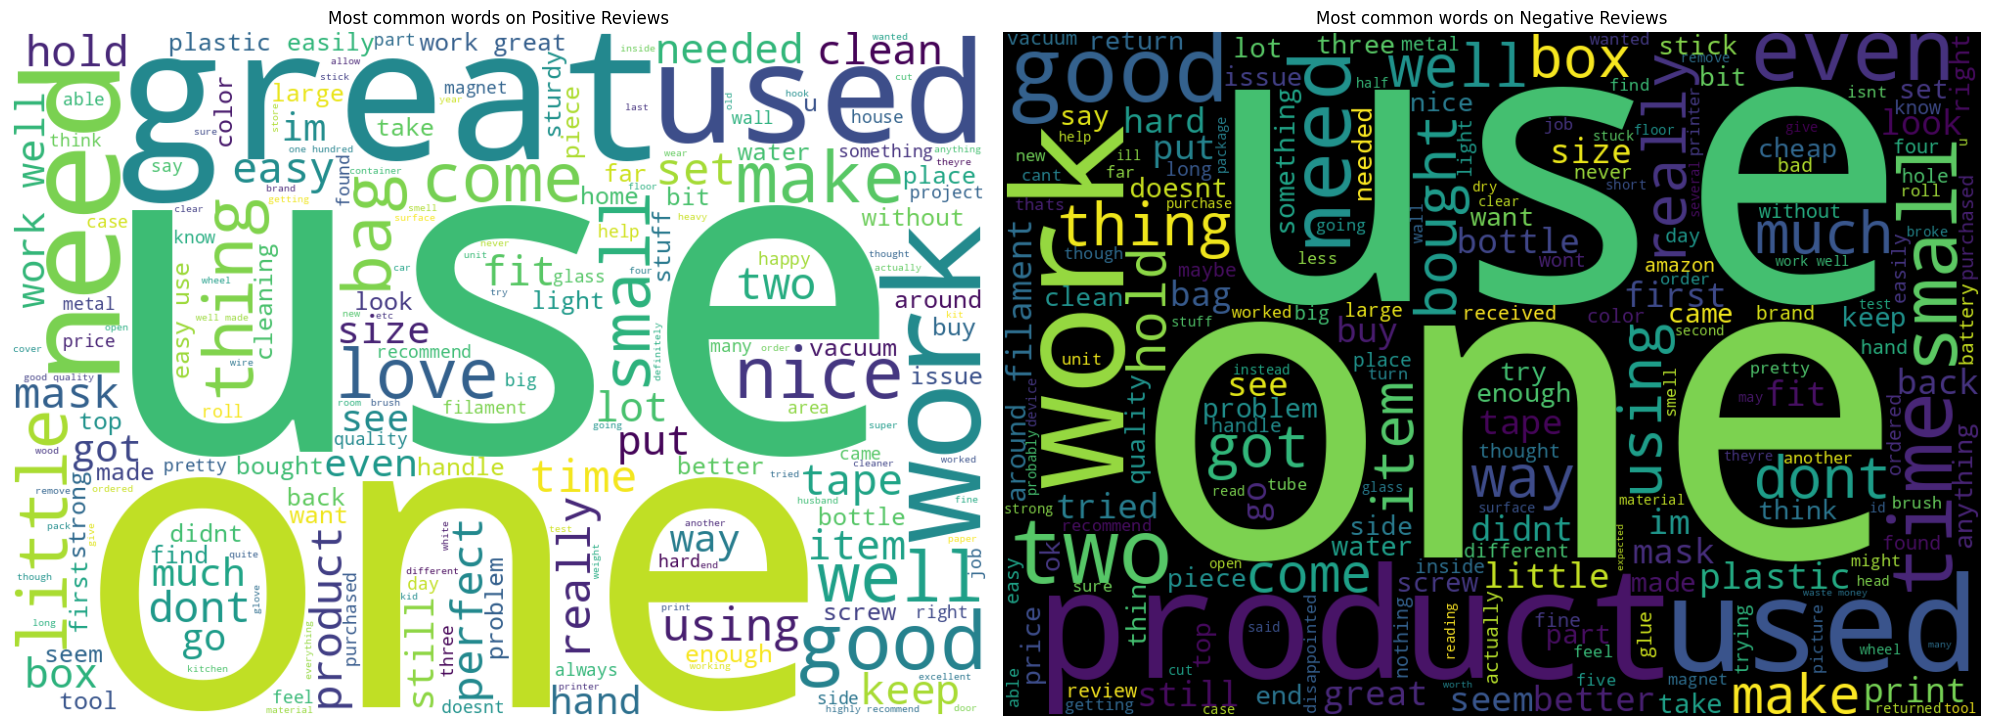

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtramos las rese√±as positivas y negativas basadas en el rango de 'sentiment'
positive_reviews = df_clean[df_clean['sentiment'] > 3]['lemmatized_review']
negative_reviews = df_clean[df_clean['sentiment'] <= 3]['lemmatized_review']

# Concatenar todas las rese√±as positivas y negativas en un solo texto
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Generamos las nubes de palabras
positive_wordcloud = WordCloud(width=1000, height=700, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=1000, height=700, background_color='black').generate(negative_text)

# Mostramos las nubes de palabras
plt.figure(figsize=(20, 10))

# Nube de palabras positivas
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words on Positive Reviews')

# Nube de palabras negativas
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words on Negative Reviews')

plt.tight_layout()
plt.show()


*   ‚ûï**Rese√±as Positivas**

 "good", "great", "love", "perfect", "fit", "quality", "easy", "works", "recommend".

Las palabras como "good", "great", "perfect" y "love" son indicativas de que las rese√±as en esta categor√≠a son generalmente muy positivas. Los usuarios est√°n expresando satisfacci√≥n con los productos, destacando aspectos como la calidad, el ajuste y la facilidad de uso.

T√©rminos como "recommend" sugieren que los clientes est√°n dispuestos a recomendar el producto, lo cual es un fuerte indicio de una experiencia positiva.

"Fit", "quality" y "perfect" apuntan a que los productos que se rese√±an tienen caracter√≠sticas que cumplen o superan las expectativas del consumidor.

Palabras como "easy", "works" y "love" apuntan a una experiencia de usuario satisfactoria, sin problemas importantes.


*   ‚ûñ**Rese√±as Negativas**

"dont", "poor", "not", "waste", "returned", "cheap", "no", "wouldnt", "problem".

La presencia de "dont", "not" y "no" indica una clara tendencia hacia el rechazo o insatisfacci√≥n con el producto. Las palabras negativas son prominentes, lo que indica que los usuarios se est√°n enfocando en aspectos decepcionantes o problem√°ticos.

T√©rminos como "poor", "waste", "cheap", y "problem" refuerzan la idea de que los consumidores est√°n destacando fallas importantes en los productos, ya sea en su desempe√±o, calidad o utilidad.

"Returned" sugiere que los usuarios han tenido que devolver los productos, lo cual es un signo claro de insatisfacci√≥n.

La palabra "wouldnt" tambi√©n implica una falta de recomendaci√≥n o disposici√≥n para volver a comprar el producto, lo que muestra una experiencia negativa en general.



   üí°**Plan en modelado**

*   Mejorar el modelo: Si bien las nubes de palabras ya muestran una buena distinci√≥n entre rese√±as positivas y negativas, ser√≠a √∫til usar estas observaciones para ajustar y entrenar un modelo de clasificaci√≥n supervisada con t√©cnicas de NLP m√°s avanzadas (como TF-IDF o word embeddings) para mejorar la precisi√≥n en la predicci√≥n de sentimientos.

*   Considerar el contexto: Las nubes de palabras se enfocan en palabras aisladas. Para entender mejor el sentimiento detr√°s de las rese√±as, el an√°lisis de las frases completas y el contexto en que se usan esas palabras ser√° crucial, lo cual se puede lograr con modelos como los basados en transformers (por ejemplo, BERT, GPT) que capturan el contexto completo de las palabras.

## **Chequear Dispersi√≥n L√©xica**

Quiero revisar la frecuencia de esas most common words a lo largo del corpus y cuan dispersas estan en el conjunto de documentos.


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.8/12.8 MB 48.3 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
‚ö† Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


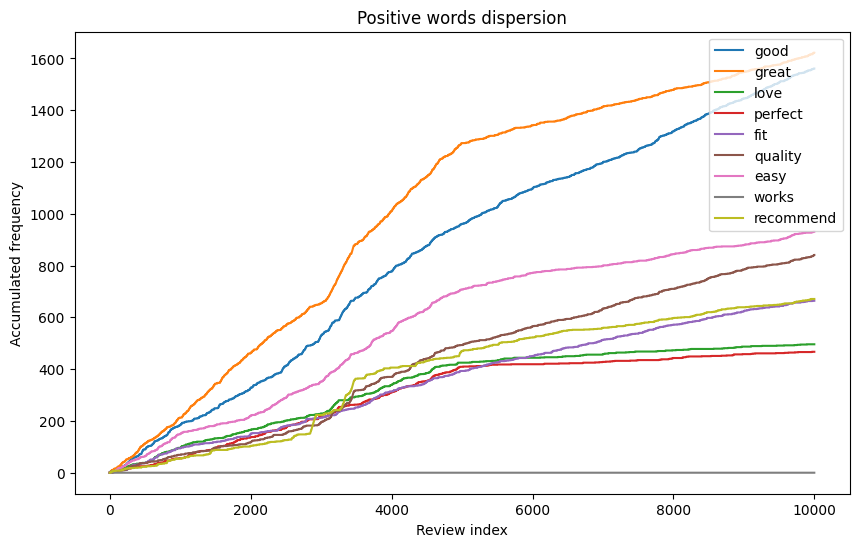

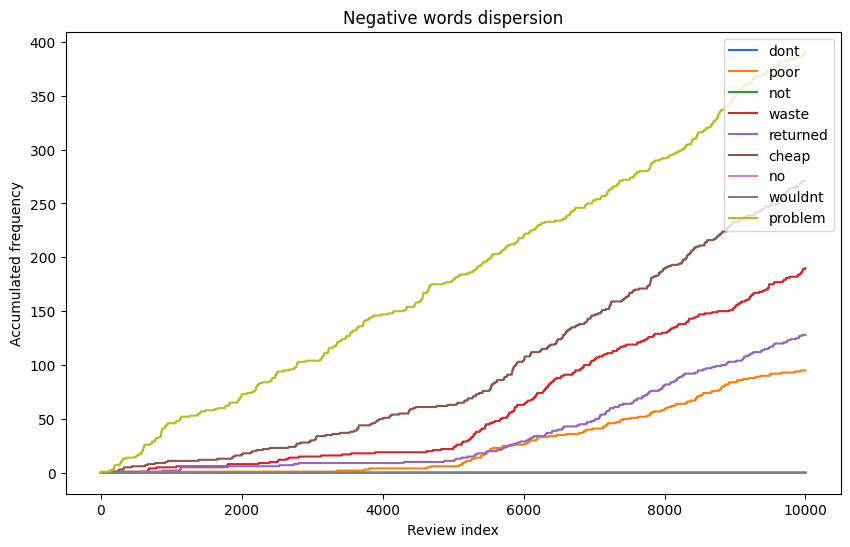

In [ ]:
import spacy
import matplotlib.pyplot as plt
import re

# Cargar el modelo de spaCy en ingl√©s
nlp = spacy.load('en_core_web_sm')

# Funci√≥n para eliminar los marcadores <PHRASE> y </PHRASE>
def clean_phrases(text):
    """Elimina las marcas de frases <PHRASE> y sus correspondientes etiquetas"""
    text = re.sub(r'<PHRASE>', '', text)
    text = re.sub(r'</PHRASE>', '', text)
    return text

# Funci√≥n para procesar el texto con spaCy
def spacy_tokenizer(text):
    # Limpiar las marcas de frases antes de procesar con spaCy
    text = clean_phrases(text)

    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

# Aplicar el tokenizador spaCy al texto
df_clean['tokens'] = df_clean['lemmatized_review'].apply(spacy_tokenizer)

# Definir las palabras positivas y negativas
positive_words = ['good', 'great', 'love', 'perfect', 'fit', 'quality', 'easy', 'works', 'recommend']
negative_words = ['dont', 'poor', 'not', 'waste', 'returned', 'cheap', 'no', 'wouldnt', 'problem']

# Funci√≥n para crear la dispersi√≥n de palabras
def plot_word_dispersion(words, title):
    plt.figure(figsize=(10, 6))
    for word in words:
        plt.plot(df_clean['tokens'].apply(lambda tokens: word in tokens).cumsum(), label=word)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel('Review index')
    plt.ylabel('Accumulated frequency')
    plt.show()

# Graficar la dispersi√≥n de palabras positivas y negativas
plot_word_dispersion(positive_words, 'Positive words dispersion')
plot_word_dispersion(negative_words, 'Negative words dispersion')


## **An√°lisis de gr√°ficos de dispersi√≥n:**

*   **Dispersi√≥n de las Palabras Positivas:**

Palabras como "good", "great", "love", "perfect", "fit", "quality":

Se puede observar que estas palabras aparecen a lo largo de las rese√±as, pero con cierto patr√≥n en su distribuci√≥n.
"Good" y "great" parecen ser de las m√°s frecuentes en las rese√±as, y se distribuyen a lo largo de las rese√±as, especialmente al principio, lo que indica que los usuarios tienden a usarlas de manera consistente para describir sus experiencias.
"Perfect" y "quality" tienden a tener picos en ciertas partes de las rese√±as, lo que podr√≠a sugerir que son utilizadas para enfatizar aspectos clave de los productos.
El uso de estas palabras puede indicar rese√±as que dan un feedback positivo de manera directa. Esto podr√≠a reflejar emociones fuertes o satisfacci√≥n.

*   **Dispersi√≥n de las Palabras Negativas:**

Palabras como "dont", "poor", "not", "waste", "returned", "cheap":

"Dont" y "not" parecen estar presentes en muchas rese√±as, lo que refleja una tendencia a expresar negaciones o cr√≠ticas. La presencia de estas palabras puede indicar rese√±as con un tono neutral a negativo, ya que son comunes cuando los usuarios se√±alan aspectos que no les gustan.

"Poor" y "cheap" aparecen en puntos espec√≠ficos, sugiriendo que se utilizan en rese√±as que detallan experiencias m√°s negativas o frustrantes, donde se destacan deficiencias o expectativas no cumplidas.

"Returned" y "waste" reflejan una fuerte insatisfacci√≥n y problemas con el producto, posiblemente en el contexto de devoluciones o mal uso del producto.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


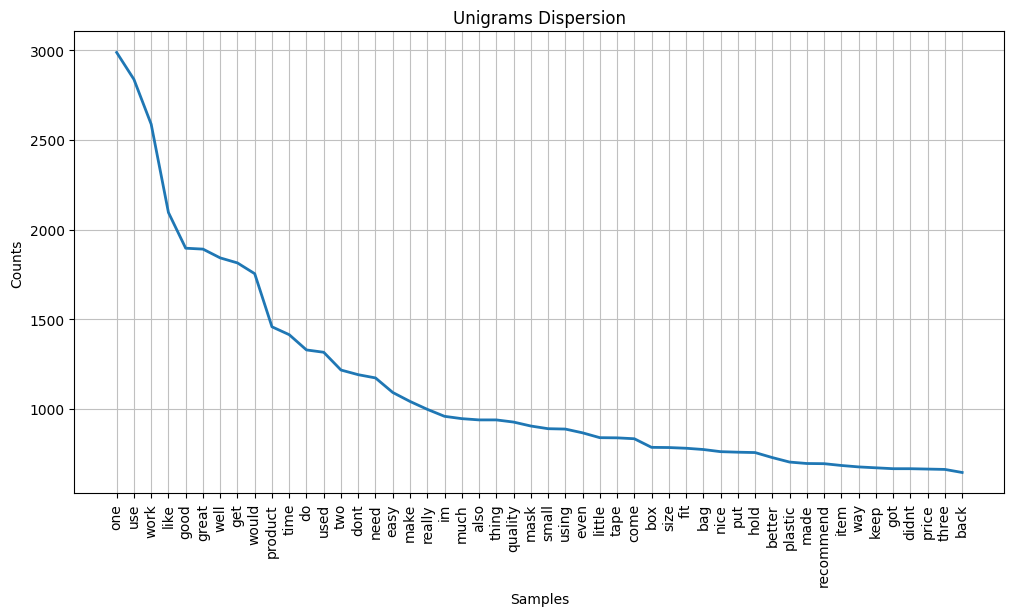

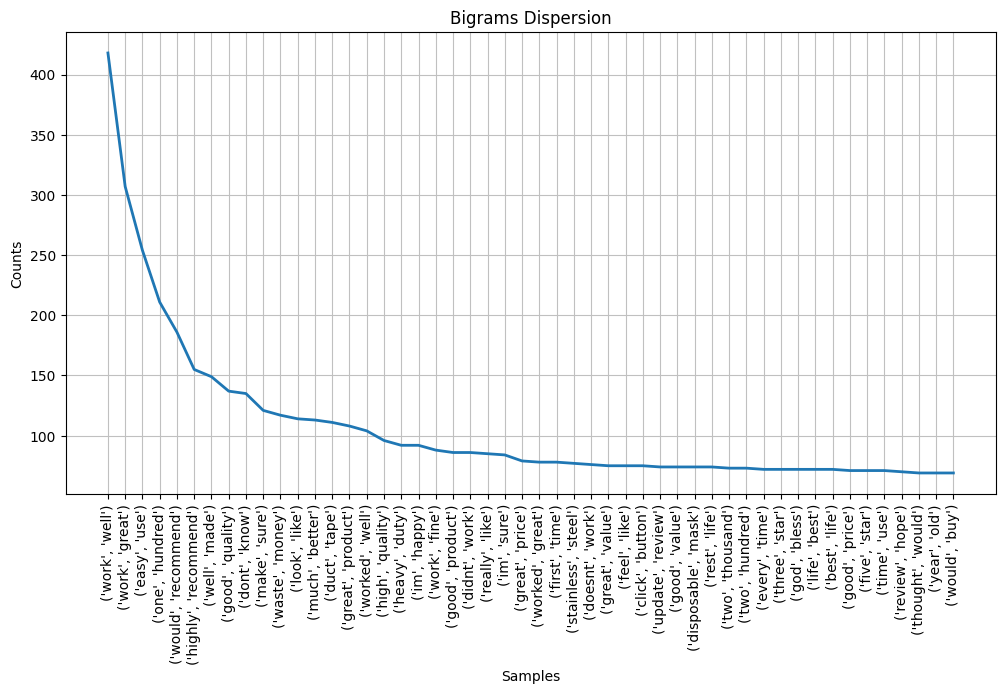

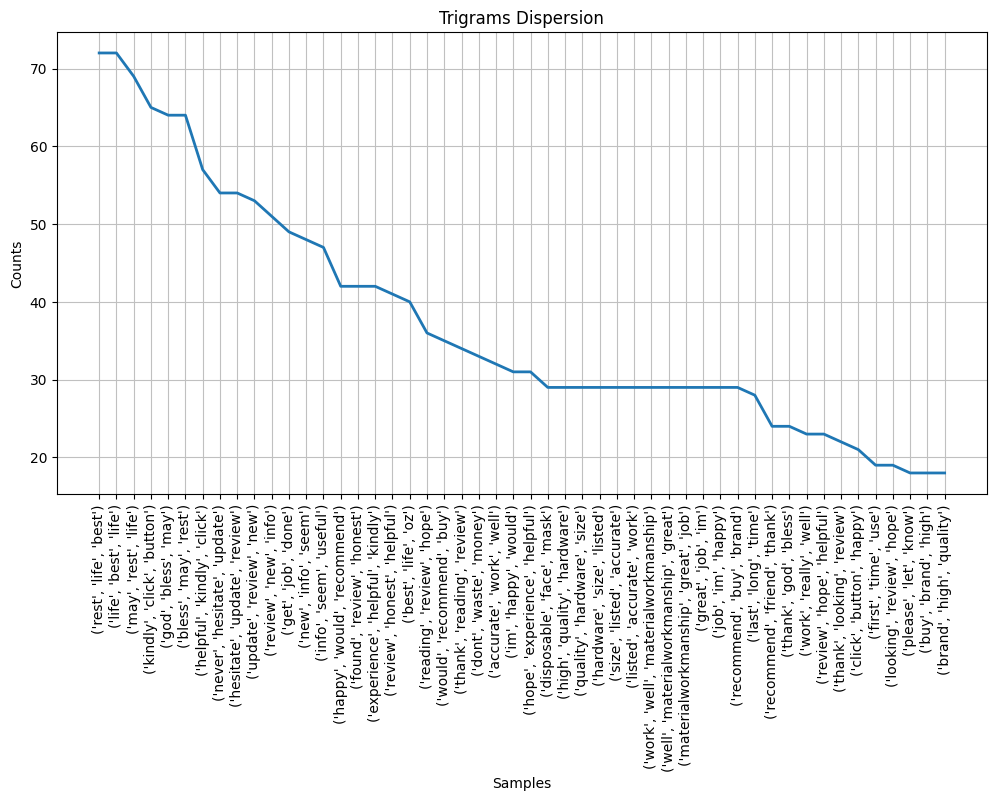

In [ ]:
import nltk
import re
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.util import ngrams

# Descargar stopwords si a√∫n no est√°n disponibles
nltk.download('stopwords')

# Lista de stopwords en ingl√©s (ya personalizada previamente, ahora excluimos "do" y eliminamos contracciones)
stopwords_dict = {
    'en': set(stopwords.words('english')) - {"do"}  # Excluimos "do" para preservarlo
}

# A√±adir manualmente las contracciones a eliminar (como 'i've', 'you're', 'we're', etc.)
stopwords_dict['en'] = stopwords_dict['en'].union({"i've", "ive", "you're", "we're", "they're", "he's", "she's"})

# Usamos la lista personalizada de stopwords
stop_words = stopwords_dict['en']

# Funci√≥n para preservar las frases clave durante el procesamiento
def preserve_phrases(sent, phrases):
    """Reemplaza las frases clave con un marcador temporal para preservarlas"""
    for phrase in phrases:
        sent = sent.replace(phrase, f"<PHRASE>{phrase}<PHRASE>")  # marcador temporal
    return sent

# Funci√≥n para restaurar las frases clave despu√©s de eliminar las stopwords
def restore_phrases(sent, phrases):
    """Restaura las frases clave desde el marcador temporal"""
    for phrase in phrases:
        sent = sent.replace(f"<PHRASE>{phrase}<PHRASE>", phrase)  # Restaurar la frase original
    return sent

# Obtener las 200 frases m√°s frecuentes (como frases clave)
key_phrases = get_frequent_phrases(df_clean['cleaned_review'].values, top_n=200)

# Concatenar todas las rese√±as en un solo texto
all_reviews = ' '.join(df_clean['lemmatized_review'])

# **Paso 1**: Preservar las frases clave antes de la tokenizaci√≥n y eliminaci√≥n de stopwords
all_reviews_preserved = preserve_phrases(all_reviews, key_phrases)

# **Paso 2**: Tokenizaci√≥n simple utilizando expresiones regulares
words = re.findall(r'\b\w+\b', all_reviews_preserved.lower())  # \b\w+\b busca palabras

# **Paso 3**: Eliminar stopwords y palabras con un solo car√°cter
filtered_words = [word for word in words if word not in stop_words and len(word) > 1]

# **Paso 4**: Eliminar las marcas de frases "<PHRASE>" antes de procesar
filtered_words = [word for word in filtered_words if 'phrase' not in word]

# **Paso 5**: Generaci√≥n de unigrams, bigrams y trigrams
unigrams = filtered_words  # Los unigrams son simplemente las palabras despu√©s del filtrado
bigrams = list(ngrams(filtered_words, 2))  # Genera bigrams
trigrams = list(ngrams(filtered_words, 3))  # Genera trigrams

# Calcular la frecuencia de unigrams, bigrams y trigrams
unigram_freq = FreqDist(unigrams)
bigram_freq = FreqDist(bigrams)
trigram_freq = FreqDist(trigrams)

# Seleccionar los 50 unigrams, bigrams y trigrams m√°s comunes
most_common_unigrams = unigram_freq.most_common(50)
most_common_bigrams = bigram_freq.most_common(50)
most_common_trigrams = trigram_freq.most_common(50)

# **Generar gr√°ficos de dispersi√≥n** para los unigrams, bigrams y trigrams m√°s comunes
# Unigrams
plt.figure(figsize=(12,6))
unigram_freq.plot(50, cumulative=False)
plt.title("Unigrams Dispersion")
plt.show()

# Bigrams
plt.figure(figsize=(12,6))
bigram_freq.plot(50, cumulative=False)
plt.title("Bigrams Dispersion")
plt.show()

# Trigrams
plt.figure(figsize=(12,6))
trigram_freq.plot(50, cumulative=False)
plt.title("Trigrams Dispersion")
plt.show()


## **Distribuci√≥n de frecuencias:**

El gr√°fico muestra que hay varias palabras con alta frecuencia, y algunas otras con baja frecuencia. Esto indica que el conjunto de reviews est√° sesgado hacia algunas palabras comunes que se repiten a menudo (como "good" y "love"), mientras que las palabras menos frecuentes son m√°s espec√≠ficas.

# **Pipeline de Normalizaci√≥n - Preprocesado**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


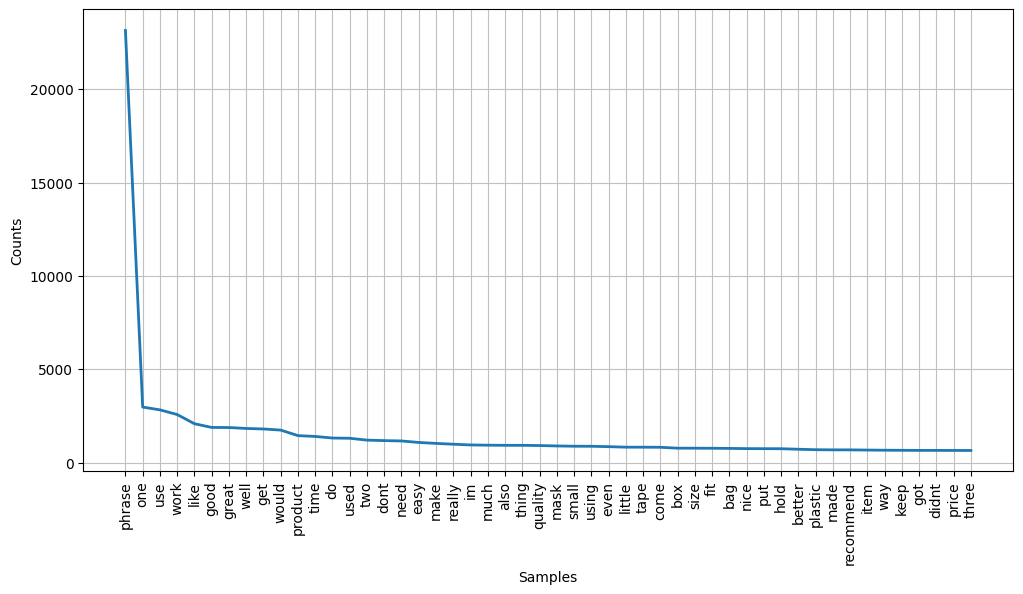

In [ ]:
import re
import num2words
import nltk
from langdetect import detect, LangDetectException
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from collections import Counter

# Descargar los recursos de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Diccionario de stopwords para lenguajes
stopwords_dict = {
    'en': set(stopwords.words('english')) - {"do"},  # Excluimos "do" para preservarlo
    'es': set(stopwords.words('spanish')),
    'fr': set(stopwords.words('french')),
    'de': set(stopwords.words('german')),
    'it': set(stopwords.words('italian')),
    'nl': set(stopwords.words('dutch')),
    'pt': set(stopwords.words('portuguese')),
    'ru': set(stopwords.words('russian')),
    'ar': set(stopwords.words('arabic')),
}

# Personalizaci√≥n de stopwords
stopwords_dict['en'] = stopwords_dict['en'].union({"i've", "ive", "you're", "we're", "they're", "he's", "she's"})

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Funci√≥n para tokenizar el texto
def simple_word_tokenize(text):
    # Eliminar caracteres no alfanum√©ricos y separar por espacio
    words = re.findall(r'\b\w+\b', text.lower())  # Convertir a min√∫sculas
    return words

# Funci√≥n para limpiar el texto (etiquetas HTML, n√∫meros, caracteres especiales)
def clean_text(text):
    # 1. Eliminar etiquetas HTML usando BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Convertir los n√∫meros a palabras
    text = re.sub(r'\b\d+\b', lambda x: num2words.num2words(int(x.group())), text)

    # 3. Eliminar caracteres especiales (excepto las palabras)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Convertir el texto a min√∫sculas
    text = text.lower()

    # 5. Eliminar espacios al inicio y al final
    text = text.strip()

    return text

# Funci√≥n para identificar las palabras m√°s frecuentes en el texto
def get_frequent_phrases(reviews, top_n=200):
    vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
    X = vectorizer.fit_transform(reviews)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

    # Ordenar las palabras por frecuencia
    sorted_phrases = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return [phrase[0] for phrase in sorted_phrases[:top_n]]  # Selecciona las top_n frases frecuentes

# Funci√≥n para preservar las frases clave con un marcador temporal
def preserve_phrases(sent, phrases):
    """Reemplaza las frases clave con un marcador temporal para preservarlas"""
    for phrase in phrases:
        sent = sent.replace(phrase, f"<PHRASE>{phrase}<PHRASE>")  # Este ser√° el marcador temporal
    return sent

# Funci√≥n para restaurar las frases clave despu√©s de eliminar las stopwords
def restore_phrases(sent, phrases):
    """Restaura las frases clave desde el marcador temporal"""
    for phrase in phrases:
        sent = sent.replace(f"<PHRASE>{phrase}<PHRASE>", phrase)  # Restaurar la frase original
    return sent

# Funci√≥n para eliminar stopwords
def remove_stopwords(text, language, preserved_phrases):
    words = simple_word_tokenize(text)  # Usar la tokenizaci√≥n personalizada
    stop_words = stopwords_dict.get(language, set())  # Obtener stopwords para el idioma detectado

    # Filtrar las stopwords y preservar las palabras clave
    filtered_words = [word for word in words if word not in stop_words and word not in preserved_phrases]

    return ' '.join(filtered_words)

# Funci√≥n para eliminar los marcadores <PHRASE> y cualquier otro texto irrelevante
def clean_phrases(text):
    """Elimina las marcas de frases <PHRASE> y sus correspondientes etiquetas"""
    text = re.sub(r'<PHRASE>', '', text)
    text = re.sub(r'</PHRASE>', '', text)
    return text

# Funci√≥n para lematizar el texto
def lemmatize_text(text):
    # Limpiar las marcas <PHRASE> antes de lematizar
    text = clean_phrases(text)

    words = simple_word_tokenize(text)  # Usar la tokenizaci√≥n personalizada
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lematizar cada palabra
    return ' '.join(lemmatized_words)

# Funci√≥n principal de preprocesado que combina todos los pasos
def preprocess_text(df):
    # Limpiar el texto (HTML, n√∫meros, caracteres especiales)
    df['cleaned_review'] = df['review'].apply(clean_text)

    # Identificar las palabras frecuentes antes de eliminar stopwords
    key_phrases = get_frequent_phrases(df['cleaned_review'].values, top_n=200)

    # Eliminar stopwords y procesar el texto
    processed_reviews = []
    for review in tqdm(df['cleaned_review'], desc="Eliminando stopwords"):
        try:
            # Detectar el idioma y eliminar stopwords
            language = detect(review)
            processed_review = preserve_phrases(review, key_phrases)  # Preservar las frases clave
            processed_review = remove_stopwords(processed_review, language, key_phrases)
        except LangDetectException:
            processed_review = review  # Si falla la detecci√≥n de idioma, mantener el texto original
        # Restaurar las frases clave
        processed_review = restore_phrases(processed_review, key_phrases)

        # Eliminar los marcadores <PHRASE> antes de continuar
        processed_review = clean_phrases(processed_review)

        processed_reviews.append(processed_review)

    df['processed_review'] = processed_reviews

    # Lematizar el texto
    df['lemmatized_review'] = df['processed_review'].apply(lemmatize_text)

    return df

# Aplicar el preprocesado al dataframe
df_clean = preprocess_text(df_clean)

# Verificar los resultados
print(df_clean[['review', 'cleaned_review', 'processed_review', 'lemmatized_review']].head())


## **Funcion python de el preprocesado hecho**

*   Limpieza de HTML, n√∫meros, caracteres especiales: Utilizac√© BeautifulSoup para limpiar el HTML y num2words para convertir n√∫meros a palabras.

*   Identificaci√≥n de palabras frecuentes: Apliqu√© CountVectorizer para identificar por bigrams y trigrams las 200 frases m√°s frecuentes antes de eliminar las stopwords. Si aplicaba directamente el codigo de stopwrods, me eliminaba palabras como "do" que le quitaban contexto a varias frases.

*   Preservaci√≥n de frases clave: Us√© un marcador <PHRASE> para preservar las frases clave, que luego restauramos despu√©s de eliminar las stopwords. A√±adi lineas de eliminacion de la palabra PHRASE ya que en las ejecuciones del codigo de stopwords preservando frases, esa palabra estaba saliendo como most common.

*   Eliminaci√≥n de stopwords: Implement√© una versi√≥n que elimina stopwords y preserva las palabras m√°s frecuentes.

*   Restauraci√≥n de las frases clave: Me asegur√© que las frases clave preservadas se restauraran correctamente despu√©s de la eliminaci√≥n de stopwords.

*   Lematizaci√≥n de las rese√±as procesadas.

In [7]:
lemmatized_reviews = df_clean['lemmatized_review'].values

In [8]:
print('Review original: {}'.format(df_clean['review'].values[0]))
print('Review final procesada: {}'.format(lemmatized_reviews[0]))


Review original: These masks are great even though there is no 'inside' or 'outside' to let you know whether the mask is inside out or not. They do the job and I've ordered these a couple of times now without hesitation.
Review final procesada: mask great even though inside outside let know whether mask inside do job ordered couple time without hesitation


In [9]:
processed_reviews = df_clean['processed_review'].values

In [10]:
print('Review original: {}'.format(df_clean['review'].values[300]))
print('Review final procesada: {}'.format(processed_reviews[300]))

Review original: I had a tooth pulled recently and my dentist sent me home with some of these. My daughter will be having her wisdom teeth removed soon, so we'll have some of these on hand for her. They're tightly compressed cotton rolls. I actually get nosebleeds frequently and these can be used for those, too.
Review final procesada: tooth pulled recently dentist sent home daughter wisdom teeth removed soon well hand theyre tightly compressed cotton rolls actually get nosebleeds frequently used


In [11]:
df_clean.head()

review  sentiment  \
0  These masks are great even though there is no ...          5   
1  These scissors are so good they got stolen by ...          5   
2  Good. Sensor push easier to work with but thes...          4   
3  Great ORB finish & size. Bought for our laundr...          5   
4  Wow the sticking power on this stuff is crazy....          4   

                                      cleaned_review  \
0  these masks are great even though there is no ...   
1  these scissors are so good they got stolen by ...   
2  good sensor push easier to work with but these...   
3  great orb finish  size bought for our laundry ...   
4  wow the sticking power on this stuff is crazy ...   

                                    processed_review  \
0  masks great even though inside outside let kno...   
1  scissors good got stolen one home care aides r...   
2              good sensor push easier work reliable   
3   great orb finish size bought laundry room closet   
4  wow sticking power stuff crazy using mount pro...   

                                   lemmatized_review  
0  mask great even though inside outside let know...  
1  scissors good got stolen one home care aide re...  
2              good sensor push easier work reliable  
3   great orb finish size bought laundry room closet  
4  wow sticking power stuff crazy using mount pro...

## **Crear la nueva columna que intera todo el preprocesamiento fullProcessedReview**

In [16]:
import numpy as np

# Asignar las rese√±as lematizadas a la nueva columna 'fullProcessedReview'
df_clean.loc[:, 'fullProcessedReview'] = df_clean['lemmatized_review']

# Verificar cu√°ntos valores NaN hay antes de la eliminaci√≥n
initial_nan_count = df_clean['fullProcessedReview'].isna().sum()

# Reemplazar las celdas vac√≠as por NaN en la columna 'fullProcessedReview'
df_clean['fullProcessedReview'] = df_clean['fullProcessedReview'].replace('', np.nan)

# Eliminar las filas con NaN en la columna 'fullProcessedReview'
df_fullpro = df_clean.dropna(subset=['fullProcessedReview'])

# Verificar cu√°ntos valores NaN se eliminaron
removed_nan_count = initial_nan_count - df_fullpro['fullProcessedReview'].isna().sum()

# Imprimir los resultados
print(f"Se eliminaron {removed_nan_count} registros con NaN en 'fullProcessedReview'.")

# Verificar los resultados en la columna 'fullProcessedReview'
print(df_fullpro[['review', 'lemmatized_review', 'fullProcessedReview']].head(15))


Se eliminaron 0 registros con NaN en 'fullProcessedReview'.
                                               review  \
0   These masks are great even though there is no ...   
1   These scissors are so good they got stolen by ...   
2   Good. Sensor push easier to work with but thes...   
3   Great ORB finish & size. Bought for our laundr...   
4   Wow the sticking power on this stuff is crazy....   
5   I love this sign, live on a corner and near 2 ...   
6   Comfortable, doesn‚Äôt fray, value for money for...   
7   good fit. . . . just a few adjustments of soun...   
8   Took some time to get but it's coming from Chi...   
9                         Good product, fast shipping   
10  This product is necessary in order to keep an ...   
11                                    Hand protection   
12                                         It‚Äôs great   
13                           Fit nicely and wear well   
14  This is the easiest way to remove ugly fuzz bi...   

                       

In [17]:
# guardar df_fullpro con full preprocesado
df_clean.to_pickle('/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_fullpro.pkl')